In [1]:
%%time
import asyncio

import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

from binance import AsyncClient, BinanceSocketManager, Client, ThreadedWebsocketManager
import Artha.configs.binance_config as c 
key = c.apis[0][0]
secret = c.apis[0][1]
client = Client(key, secret)

import asyncio
import time
import nest_asyncio
nest_asyncio.apply()

# client.get_historical_klines("ETHBTC", "1h", "1 Dec, 2017", "1 Jan, 2018")
import pandas as pd
import matplotlib.pyplot as plt

# from Artha.mentions import *
from datetime import datetime, timedelta
import numpy as np

import matplotlib as mpl
from mplfinance.original_flavor import candlestick_ohlc
import ta
import matplotlib.dates as dates

from Artha.trading import *

markets = get_quote_dict()
btc_markets = [tick+asset for asset in list(markets.keys())[:1] for tick in markets[asset]]

CPU times: user 1.26 s, sys: 230 ms, total: 1.49 s
Wall time: 2.71 s


In [2]:
%%time
import concurrent.futures
start_date, window_count = "03/01/2021 00:00:00", 63
def save_klines(asset):
    klines = get_klines(asset, "1h", start_date)
    df = get_klines_df(klines)
    df.to_csv("../data/crypto_price_data/"+asset+".csv", index=True)
    return "done "+asset

def all_klines(all_assets):
    with concurrent.futures.ThreadPoolExecutor(max_workers = 60) as executor:
        result = [executor.submit(save_klines, asset) for asset in all_assets]
    for future in concurrent.futures.as_completed(result):
        print(future.result())
    
# all_klines(np.setdiff1d(btc_markets[:30], dd))
# dd = [i[:-4] for i in os.listdir("../data/crypto_price_data/")]

# np.setdiff1d(dd, btc_markets[:30])
save_klines("MATICBTC")

CPU times: user 119 ms, sys: 13 ms, total: 132 ms
Wall time: 2.92 s


'done MATICBTC'

In [3]:
files = ["../data/crypto_price_data/"+i for i in os.listdir("../data/crypto_price_data")]
file_num = 17

df = pd.read_csv(files[file_num])
df['Date'] = pd.to_datetime(df['Unnamed: 0'])
df = df.set_index("Date").drop(['Unnamed: 0'], axis = 1)
ticker = os.listdir("../data/crypto_price_data")[file_num][:-4]
print(ticker)

MATICBTC


In [4]:
# writing tests for vol spikes
with open("../tests/test_data/trading_data.py", "w+") as w:
    w.write("volume_data = [\n")
    w.write("("+str(list(df["Volume"].iloc[1640:1648])) + ", "+str([6, 7]) + ", "+str(2)+"),\n")
    w.write("("+str(list(df["Volume"].iloc[253:259])) + ", "+str([3]) + ", "+str(2)+"),\n")
    w.write("]")

In [4]:
ticker = "ETHUSDT"
klines = get_klines(ticker, "4h", "03/01/2021 00:00:00")
df = get_klines_df(klines)
ind_ichi = ta.trend.IchimokuIndicator(df["High"],
                                      df["Low"],
                                      df["Close"])
df = ichimoku(df, ind_ichi)

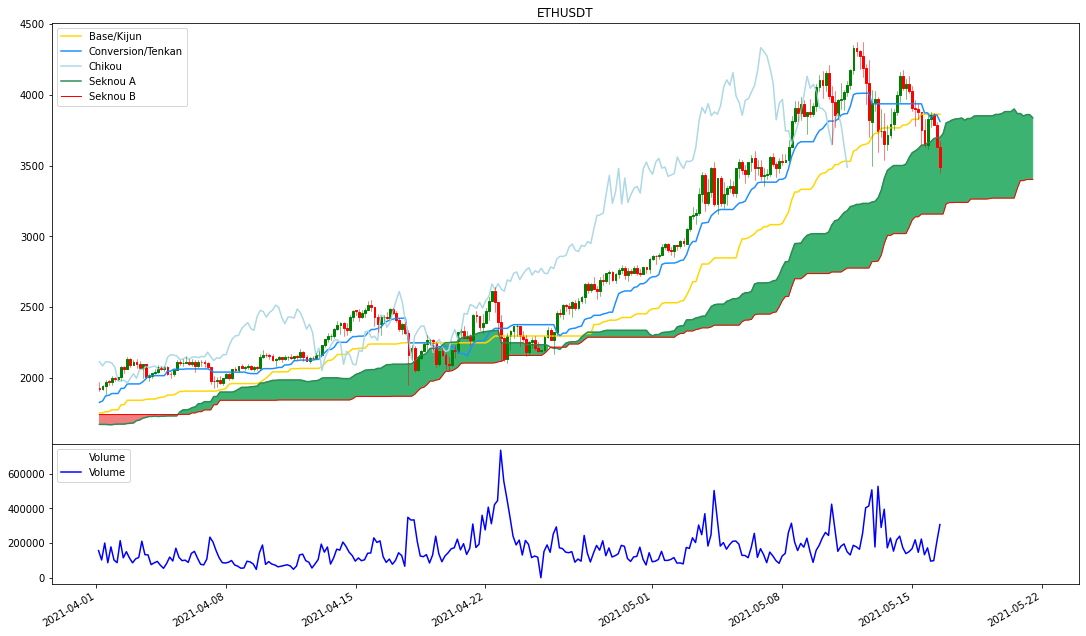

CPU times: user 2.08 s, sys: 63.3 ms, total: 2.14 s
Wall time: 1.95 s


In [5]:
%%time
plt.rcParams['figure.figsize'] = [15,10]
window = 30

# x = np.arange(1600, 1760)
x = np.arange(0, 180)
# x = np.append(np.arange(180,len(df)-1), np.arange(len(df)-1, len(df)-1+window))

data = df.loc["2021-04-01 00:00:00":]
# data = df


fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1], 'hspace':0})
fig.tight_layout()
plt.gcf().autofmt_xdate()
axs[0].set_title(ticker)

axs[0].plot(data.index, data.kijun_sen, label='Base/Kijun', color = "gold")
axs[0].plot(data.index, data.tenkan_sen, label='Conversion/Tenkan', color ="dodgerblue")
axs[0].plot(data.index, data.Close.shift(-window), label='Chikou', color ="lightblue")

axs[0].plot(data.index, data.senkou_span_a, label='Seknou A', color = "seagreen")
axs[0].plot(data.index, data.senkou_span_b, label='Seknou B', color = "red", linewidth=1)
axs[0].fill_between(data.index, data.senkou_span_a, data.senkou_span_b, where = (data.senkou_span_a > data.senkou_span_b), color = "mediumseagreen")
axs[0].fill_between(data.index, data.senkou_span_a, data.senkou_span_b, where = (data.senkou_span_a < data.senkou_span_b), color = "lightcoral")

quotes = [(dates.date2num(x[0]), x[2], x[3], x[4], x[5]) for x in data.itertuples()]
candlestick_ohlc(axs[0], quotes, width=.1, colorup='g', colordown='r');

axs[0].legend(loc="upper left")
axs[1].plot(data.index, np.zeros(len(data.index)), label='Volume', color ="blue", linewidth = 0)
axs[1].plot(data.index, data.Volume, label='Volume', color ="blue")
axs[1].legend(loc="upper left")
plt.show()

In [ ]:
async def single(name):
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client, user_timeout = 20)
    # start any sockets here, i.e a trade socket
    ts = bm.kline_socket(name, interval="5m")
    # then start receiving messages
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            print(res)
   
    await client.close_connection()

async def multiple (asset_names):
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client, user_timeout = 20)
    # start any sockets here, i.e a trade socket
    ms = bm.multiplex_socket(asset_names)
    # then start receiving messages
    async with ms as tscm:
        while True:
            res = await tscm.recv()
            print(res["data"]["k"])
   
    await client.close_connection()

In [ ]:
import Artha.crypto_data as crypto
markets = crypto.get_market_dict()
print("BTC" in [markets.keys()])
print("BTC" in [i for i in crypto.get_invert_dict(markets).keys()])
s_type = "@kline_5m"
btc_markets = [(tick+asset+s_type).lower() for asset in list(markets.keys())[:1] for tick in markets[asset]]

In [ ]:
loop = asyncio.get_event_loop()
loop.run_until_complete(multiple(btc_markets[:3]))
print("done")

In [ ]:
symbol = 'BNBBTC'

twm = ThreadedWebsocketManager(api_key=key, api_secret=secret)
# start is required to initialise its internal loop
twm.start()

def handle_socket_message(msg):
    print(f"message type: {msg['e']}")
    print(msg)

twm.start_kline_socket(callback=handle_socket_message, symbol=symbol)

# multiple sockets can be started
twm.start_depth_socket(callback=handle_socket_message, symbol=symbol)

# or a multiplex socket can be started like this
# see Binance docs for stream names
streams = ['BNBBTC@miniTicker', 'BNBBTC@bookTicker']
twm.start_multiplex_socket(callback=handle_socket_message, streams=streams)

In [ ]:
start_date, window_count = "03/01/2021 00:00:00", 63

dates = [from_datetime(to_datetime(start_date)+timedelta(days=i)) for i in range(window_count)]

pdrank = pd.read_csv("pgrankdata.csv")
pdrank['Date'] = pd.to_datetime(pdrank['Unnamed: 0'])
pdrank = pdrank.set_index("Date").drop(['Unnamed: 0'], axis = 1)

i = 0
ticker = "DOGE"

while i<len(dates)-1:
    if pdrank[ticker][i]!=0:
        di = pdrank[ticker][i+1]/pdrank[ticker][i]
        if di> 1.1:
            print(i, di, pdrank[ticker][i+1], pdrank[ticker][i])
            print(pdrank[ticker].index[i+1])
    else:
        if pdrank[ticker][i+1] > 0:
            print("new", i, pdrank[ticker][i+1])
    i+=1

In [ ]:
# direct from neo

inc = 32
wind = 30

if ticker == "BTC":
    asset = ticker+"USDT"
else:
    asset = ticker+"BTC"

interval = '2h'
newest, oldest = pdrank[ticker].index[inc-wind: inc+wind][-1].to_pydatetime().timestamp() * 1000, pdrank[ticker].index[inc-wind: inc+wind][0].to_pydatetime().timestamp() * 1000, 
df = crypto.get_klines_df(asset, interval, str(oldest), str(newest))
df.keys()


plt.rcParams['figure.figsize'] = [10, 5]
ts = df["Volume"].astype(float) #.pct_change()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(pdrank[ticker].index[inc-wind: inc+wind], pdrank[ticker][inc-wind: inc+wind], color='b')

ax2.plot(ts.index, ts, color='g')

ax1.set_xlabel('Time')
ax1.set_ylabel(ticker+" PageRank Score", color='b')
ax2.set_ylabel(ticker +" Price", color='g')
# plt.plot([inc]*2, range(-1,1))
plt.title(asset+" "+from_datetime(pdrank[ticker].index[inc].to_pydatetime())[:-9])
plt.gcf().autofmt_xdate()